In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#ML Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Feature Engineering
from imblearn.pipeline import Pipeline as ImbPipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler,RobustScaler

# Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import average_precision_score,confusion_matrix, classification_report, f1_score, recall_score, precision_score, SCORERS

# Saving models
import pickle 
import joblib

# DATA ANALYSIS

Class 1 : Bad Client<br>
Class 0 : Good Client

TARGET:
Try to minimize Bad Client, and make sure the predicted bad client is correct

## Load Data

In [586]:
appRecord= pd.read_csv('application_record.csv')
appRecord.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [587]:
credRecord = pd.read_csv('credit_record.csv')
credRecord.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


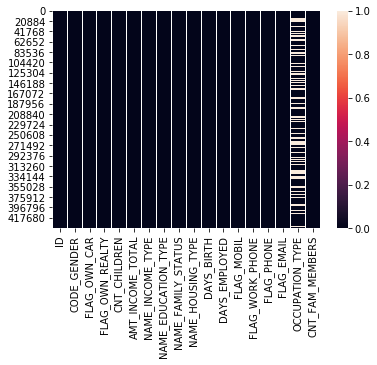

In [588]:
sns.heatmap(appRecord.isnull())

Plenty null value in Occupation Type, this feature will be dropped

In [589]:
appRecord.drop(['OCCUPATION_TYPE'],axis=1,inplace=True)

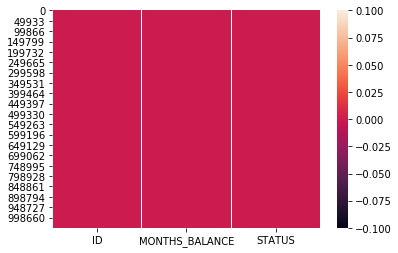

In [590]:
sns.heatmap(credRecord.isnull())

Credit Record data seems good, no null value

In [591]:
#Original lengths
len(appRecord)

438557

In [592]:
# We were told that there could be duplicates in application record
#Checking unique value, and we found it less than the original, we can confirm that there are duplicates
len(np.unique(appRecord['ID']))

438510

In [593]:
#Dropping duplicates
appRecord = appRecord.drop_duplicates('ID', keep='last') 
len(appRecord)

438510

In [594]:
len(np.unique(credRecord['ID']))

45985

In [595]:
# Checking intersection ID between two file
len(set(credRecord['ID']).intersection(set(appRecord['ID'])))

36457

In [596]:
# Filter out non intersect id
nonIntersectId = list(set(credRecord['ID']).intersection(set(appRecord['ID'])))
credRecord = credRecord[credRecord['ID'].isin(nonIntersectId)]

In [597]:
len(np.unique(credRecord['ID']))

36457

## Define Class

* Customer will be analyzed and filtered to get fair comparison
* Customers will be classified as Bad Client and Good Client
* Class will be determined by credit points: <br>
-Equal or more than zero = Good Client<br>
-Less than zero = Bad Client

### Analyze Status

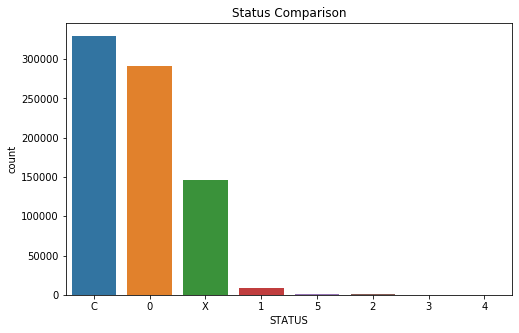

In [810]:
plt.figure(figsize=(8,5))
plt.title('Status Comparison')
sns.countplot(credRecord['STATUS'],order=pd.value_counts(credRecord['STATUS']).iloc[:10].index)
plt.savefig('status.png')

Most of the customers falls between C (Paid off the same month) and 0 (1-29 days due) Status, before followed by X (No transaction during certain month), these criteria will most likely included in Good Client attribute, while the rest (Due for more than a month) will be included in Bad Client.

In [599]:
credRecord.describe()

,ID,MONTHS_BALANCE
count,7.777150e+05,777715.000000
mean,5.078743e+06,-19.373564
std,4.180442e+04,14.082208
min,5.008804e+06,-60.000000
25%,5.044568e+06,-29.000000
50%,5.069530e+06,-17.000000
75%,5.115551e+06,-8.000000
max,5.150487e+06,0.000000


Customers joining period is varied, mainly they already join for nearly two years and the longest is five years

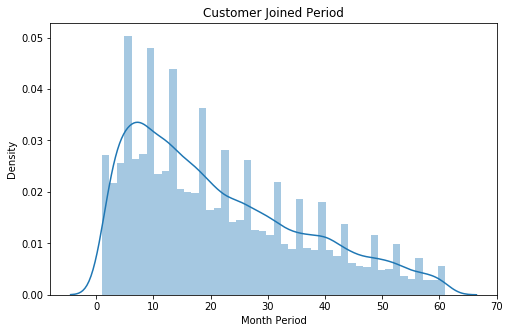

In [857]:
plt.figure(figsize=(8,5))
plt.title('Customer Joined Period')
sns.distplot(credRecord.groupby('ID').agg('count')['MONTHS_BALANCE'],kde=True)
plt.xlabel('Month Period')
plt.savefig('C:\\Users\\Aris\\Documents\\Jupyter Purwa\\Final Project\\Dashboard\\static\\join.png')

The majority is fall between 5 to 8 months old. This would be an issue as the customers not on the same page. It is not fair to compare customer that has been join for 6 months only to a customer that has been going for years. We'll try to find certain pattern during certain period on the next step

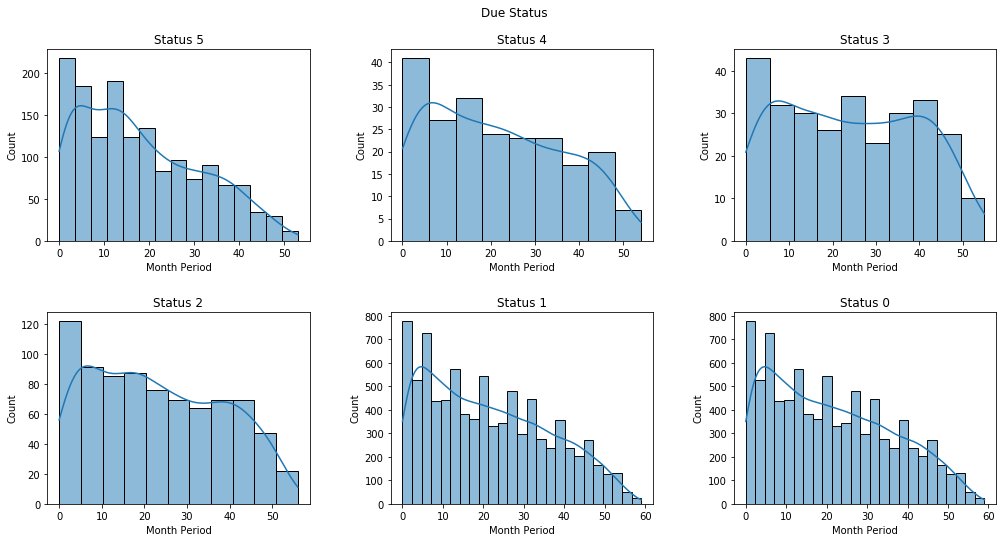

In [854]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False,sharey=False)
fig.suptitle('Due Status')
fig.tight_layout(pad=5.0)

# Status 5
sns.histplot(credRecord[credRecord['STATUS']=='5']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[0,0])
axes[0,0].set_title('Status 5')
axes[0,0].set(xlabel="Month Period")

# Status 4
sns.histplot(credRecord[credRecord['STATUS']=='4']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[0,1])
axes[0,1].set_title('Status 4')
axes[0,1].set(xlabel="Month Period")

# Status 3
sns.histplot(credRecord[credRecord['STATUS']=='3']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[0,2])
axes[0,2].set_title('Status 3')
axes[0,2].set(xlabel="Month Period")

# Status 2
sns.histplot(credRecord[credRecord['STATUS']=='2']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[1,0])
axes[1,0].set_title('Status 2')
axes[1,0].set(xlabel="Month Period")

# Status 1
sns.histplot(credRecord[credRecord['STATUS']=='1']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[1,1])
axes[1,1].set_title('Status 1')
axes[1,1].set(xlabel="Month Period")

# Status 0
sns.histplot(credRecord[credRecord['STATUS']=='1']['MONTHS_BALANCE'].apply(lambda x: x*-1),kde=True,ax=axes[1,2])
axes[1,2].set_title('Status 0')
axes[1,2].set(xlabel="Month Period")
plt.savefig('C:\\Users\\Aris\\Documents\\Jupyter Purwa\\Final Project\\Dashboard\\static\\due.png')

* All payment that was due, started to peak around 4 month and so, and the worst is status 5 that last for more than a year
* From the graphic above, we conclude that the bad client pattern could be capture in more or less for a year period
* What if the bad client turns out to be a good client in their latter period? We'll add a certain amount of period to give them a 'chance' to clean their records.
* As we know the majority of the customers has been joined for 8 months, and we'll give another 4 months. So total 12 months. What this means is all customer that has been joined less than a year will be removed and the customer that has been joined for more than a year will trimmed into a year period. So, the fair comparison is achieved.

### Filtering ID

In [602]:
#Number of ID Before filter month period
filteredCredRecord = credRecord.groupby('ID').agg('count')
len(filteredCredRecord)

36457

In [603]:
#Number of ID After filter month period
filteredCredRecord = filteredCredRecord[filteredCredRecord['MONTHS_BALANCE']>=12].reset_index()
len(filteredCredRecord)

24566

In [604]:
# Get filtered ID
usedId = np.unique(filteredCredRecord['ID'])
usedId

array([5008804, 5008805, 5008806, ..., 5150483, 5150484, 5150487],
      dtype=int64)

In [605]:
#Before filtered by ID
len(credRecord)

777715

In [606]:
#After filtered by ID
filterIdCredrecord = credRecord[credRecord['ID'].isin(usedId)]
len(filterIdCredrecord)

701218

In [607]:
# Function to trim loan period
def getOverPeriodIndex(dataFrame,period=12):
    idList = np.unique(dataFrame['ID'])
    indexList = []
    for i in idList:
        temp = dataFrame[dataFrame['ID']==i]
        dfLength = len(temp)
        cutLength = dfLength - period
        if cutLength == 0:
            continue
        else:
            indexList.extend(temp[-cutLength:].index)
    return indexList

In [608]:
removeIndex = getOverPeriodIndex(filterIdCredrecord)
removeIndex[:10]

[92950, 92951, 92952, 92953, 92966, 92967, 92968, 92981, 92982, 92983]

In [609]:
filterIdCredrecord = filterIdCredrecord[~filterIdCredrecord.index.isin(removeIndex)].reset_index(drop=True)
filterIdCredrecord.head()

,ID,MONTHS_BALANCE,STATUS
0,5008804,0,C
1,5008804,-1,C
2,5008804,-2,C
3,5008804,-3,C
4,5008804,-4,C


In [610]:
np.unique(filterIdCredrecord.groupby('ID').agg('count')['MONTHS_BALANCE'])

array([12], dtype=int64)

Trimming and filtering is success

### Assign Credit Points

Rules of Credit Points:
* X (No loan) and 0 (Due under 1 month) : 0 point
* 0 (Due for less than a month) : -1 point
* C (Paid off that month) : 1 point
* 1 (Due for a month) : -2 points
* 2 (Due for 2 months) : Instantly classified as bad client
* 3 (Due for 3 months) : Instantly classified as bad client
* 4 (Due for 4 months) : Instantly classified as bad client
* 5 (Due for 5 months) : Instantly classified as bad client

In [611]:
# Init scoring mapping
scoreMap = {'C':1,'X':0,'0':-1,'1':-2}

In [612]:
# function for assigning credit points
def getScore(dataFrame,scoreMap):
    tempDf = pd.DataFrame({'ID':[],'Period Score':[],'Final Score':[]})
    idList = np.unique(dataFrame['ID'])
    
    for i in idList:
        periodScore = []
        # Get certain id from dataFrame
        temp = dataFrame[dataFrame['ID']==i]
        dfLength = len(temp)
        statusList = np.array(temp['STATUS'])
        
        for j in statusList:
            if j in (['5','4','3','2']):
                periodScore = [-999]
                break
            else:
                periodScore.append(scoreMap[j])
        tempDf = tempDf.append({'ID':i,'Period Score':periodScore,'Final Score':np.array(periodScore).sum()},ignore_index=True)
    return tempDf

In [613]:
# Run scoring credit
scoreCredrecord = getScore(filterIdCredrecord,scoreMap)
scoreCredrecord.head()

,ID,Period Score,Final Score
0,5008804.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
1,5008805.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
2,5008806.0,"[1, 1, 1, 1, 1, 1, 1, 0, -1, -1, 0, -1]",4.0
3,5008810.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
4,5008811.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0


In [614]:
# Get good client and sort by Final Score
scoreCredrecord[scoreCredrecord['Final Score']>=0].sort_values('Final Score',ascending=False)

,ID,Period Score,Final Score
0,5008804.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
13666,5090109.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
14864,5092424.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
14870,5092432.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
14872,5092435.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",12.0
...,...,...,...
3144,5024677.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
3143,5024676.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
19825,5118242.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0
11905,5068821.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0


In [615]:
# Get good client and sort by Final Score
scoreCredrecord[scoreCredrecord['Final Score']<0].sort_values('Final Score')

,ID,Period Score,Final Score
13582,5089959.0,[-999],-999.0
6390,5045495.0,[-999],-999.0
12157,5069307.0,[-999],-999.0
17921,5113933.0,[-999],-999.0
7636,5050706.0,[-999],-999.0
...,...,...,...
13603,5089998.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]",-1.0
16116,5099954.0,"[1, 1, 1, 1, 1, 1, -2, -1, -1, -1, -1, -1]",-1.0
17440,5113023.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]",-1.0
10151,5062424.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0]",-1.0


In [616]:
# Number of Good client
len(scoreCredrecord[scoreCredrecord['Final Score']>=0])

16833

In [617]:
# Number of Bad client

In [618]:
len(scoreCredrecord[scoreCredrecord['Final Score']<0])

7733

In [619]:
len(scoreCredrecord[scoreCredrecord['Final Score']>=0])/len(scoreCredrecord)*100

68.5215338272409

In [620]:
len(scoreCredrecord[scoreCredrecord['Final Score']<0])/len(scoreCredrecord)*100

31.478466172759095

### Classifying data

In [621]:
appRecord.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


In [622]:
len(appRecord)

438510

In [623]:
#Filter ID
filteredApprecord = appRecord[appRecord['ID'].isin(usedId)]
len(filteredApprecord)

24566

In [624]:
# function to label the data
def classifyingGoodBad(dataFrame,scoreDataFrame):
    idList = np.unique(dataFrame['ID'])
    dataFrame['LABEL'] = np.nan
    
    for i in idList:
        score = int(scoreDataFrame[scoreDataFrame['ID']==i]['Final Score'])
        idx = dataFrame[dataFrame['ID']==i].index
        if score < 0:
            dataFrame['LABEL'][idx] = 1
        else:
            dataFrame['LABEL'][idx] = 0
    return dataFrame

In [625]:
dfCredit = classifyingGoodBad(filteredApprecord,scoreCredrecord)

In [626]:
dfCredit.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,LABEL
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,0.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0.0


In [627]:
#Good client
len(dfCredit[dfCredit['LABEL']==0])

16833

In [628]:
#Bad client
len(dfCredit[dfCredit['LABEL']==1])

7733

In [629]:
dfCredit['LABEL'] = dfCredit['LABEL'].astype(int)

DataFrame labeled

#### Summary: Define Class

* 1. ID between Application Record and Credit Records are different -> we manage to intersect the ID between dataframes
* 2. The length of time the customer joined varies -> Set a certain period to make the comparison fair
* 3. Defining class -> Set a credit points for each customer and classify based on the score

## Feature Analysis

In [630]:
dfCredit.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,LABEL
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,0


In [631]:
def getUniqueCounts(df,columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue = np.unique(tempDf[columnName].astype(str).values)
    counts = list(map(lambda x: len(tempDf[tempDf[columnName].astype(str)==x]),uniqueValue))
    return(uniqueValue,counts)

def countBar(df,columnName):
    return df[['LABEL',columnName,'ID']].groupby([columnName,'LABEL']).agg('count').plot(kind='barh',title=columnName.capitalize())

def getPercentageCounts(df,columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue, counts = getUniqueCounts(df,columnName)
    percentage = list(map(lambda x: x/len(tempDf)*100,counts))
    return pd.DataFrame({
        columnName:uniqueValue,
        'Counts':counts,
        'Percentage':percentage
    })

def percentagePlot(df,columnName):
    tempDf = df[df[columnName].notna()]
    uniqueValue, counts = getUniqueCounts(df,columnName)
    for index, value in enumerate(uniqueValue):
        (df[df[columnName].astype(str)==value][['LABEL',columnName,'ID']].groupby([columnName,'LABEL']).agg('count')/counts[index]*100).plot(kind='barh')
        plt.xlabel('Percentage')
        plt.title(value.capitalize())

## Categorical Feature

### CODE_GENDER

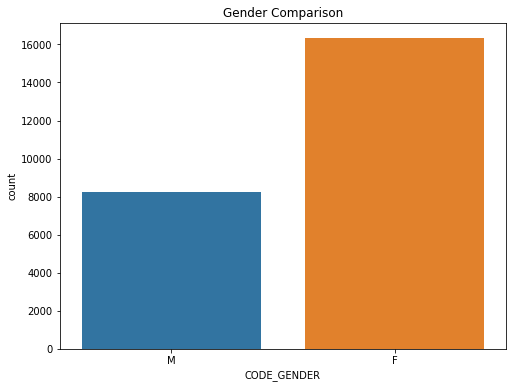

In [859]:
plt.figure(figsize=(8,6))
plt.title('Gender Comparison')
plt.xlabel('Gender')
sns.countplot(dfCredit['CODE_GENDER'])
plt.savefig('C:\\Users\\Aris\\Documents\\Jupyter Purwa\\Final Project\\Dashboard\\static\\gender.png')

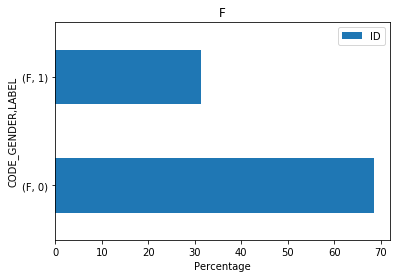

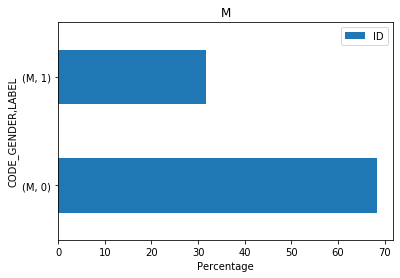

In [633]:
percentagePlot(dfCredit,'CODE_GENDER')

In [634]:
tempDf = dfCredit[['ID','CODE_GENDER','LABEL']]
(tempDf.groupby(['CODE_GENDER','LABEL']).agg('count')/len(dfCredit))*100

ID
CODE_GENDER LABEL           
F           0      45.583327
            1      20.854026
M           0      22.938207
            1      10.624440

In [635]:
(tempDf[tempDf['CODE_GENDER']=='M'].groupby(['CODE_GENDER','LABEL']).agg('count')/len(tempDf[tempDf['CODE_GENDER']=='M']))*100

ID
CODE_GENDER LABEL           
M           0      68.344451
            1      31.655549

In [636]:
(tempDf[tempDf['CODE_GENDER']=='F'].groupby(['CODE_GENDER','LABEL']).agg('count')/len(tempDf[tempDf['CODE_GENDER']=='F']))*100

ID
CODE_GENDER LABEL           
F           0      68.610992
            1      31.389008

Customers are dominated by Female, but doesn't make any significant affect into the target

### FLAG_OWN_CAR

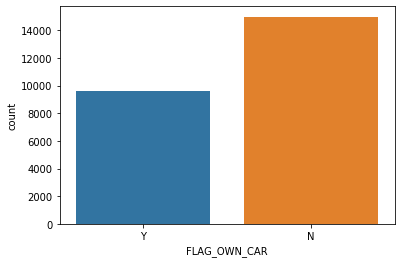

In [637]:
sns.countplot(dfCredit['FLAG_OWN_CAR'])

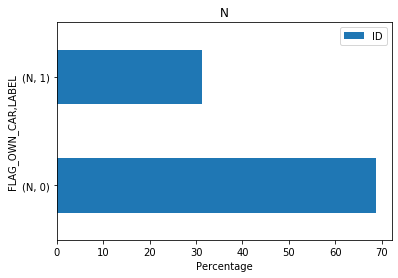

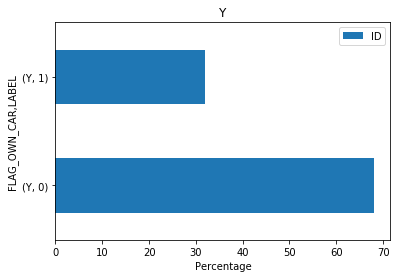

In [638]:
percentagePlot(dfCredit,'FLAG_OWN_CAR')

In [639]:
tempDf = dfCredit[['ID','FLAG_OWN_CAR','LABEL']]
(tempDf.groupby(['FLAG_OWN_CAR','LABEL']).agg('count')/len(dfCredit))*100

ID
FLAG_OWN_CAR LABEL           
N            0      41.927868
             1      19.038509
Y            0      26.593666
             1      12.439958

In [640]:
#Ratio
(tempDf[tempDf['FLAG_OWN_CAR']=='Y'].groupby(['FLAG_OWN_CAR','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_OWN_CAR']=='Y']))*100

ID
FLAG_OWN_CAR LABEL           
Y            0      68.130149
             1      31.869851

In [641]:
#Ratio
(tempDf[tempDf['FLAG_OWN_CAR']=='N'].groupby(['FLAG_OWN_CAR','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_OWN_CAR']=='N']))*100

ID
FLAG_OWN_CAR LABEL           
N            0      68.772117
             1      31.227883

Mostly do not own a car and there's no significant sign this feature could affect the target

### FLAG_OWN_REALTY

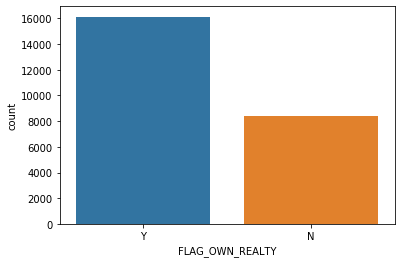

In [642]:
sns.countplot(dfCredit['FLAG_OWN_REALTY'])

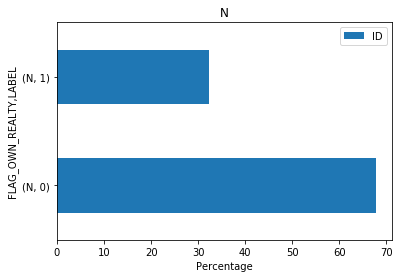

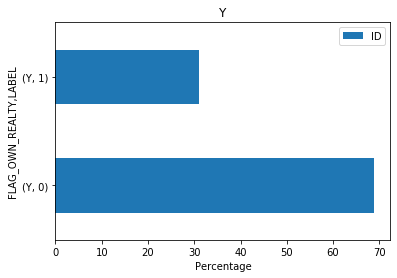

In [643]:
percentagePlot(dfCredit,'FLAG_OWN_REALTY')

In [644]:
tempDf = dfCredit[['ID','FLAG_OWN_REALTY','LABEL']]
(tempDf.groupby(['FLAG_OWN_REALTY','LABEL']).agg('count')/len(dfCredit))*100

ID
FLAG_OWN_REALTY LABEL           
N               0      23.276073
                1      11.080355
Y               0      45.245461
                1      20.398111

In [645]:
#Ratio
(tempDf[tempDf['FLAG_OWN_REALTY']=='Y'].groupby(['FLAG_OWN_REALTY','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_OWN_REALTY']=='Y']))*100

ID
FLAG_OWN_REALTY LABEL           
Y               0      68.925958
                1      31.074042

In [646]:
#Ratio
(tempDf[tempDf['FLAG_OWN_REALTY']=='N'].groupby(['FLAG_OWN_REALTY','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_OWN_REALTY']=='N']))*100

ID
FLAG_OWN_REALTY LABEL           
N               0      67.748815
                1      32.251185

* Majority of the customers own a property
* Customer that do not own realty is slightly more likely to become a bad client

### NAME_INCOME_TYPE

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

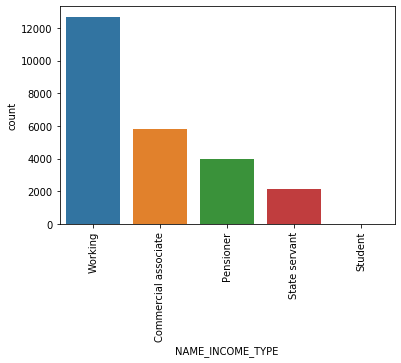

In [647]:
sns.countplot(dfCredit['NAME_INCOME_TYPE'])
plt.xticks(rotation='vertical')

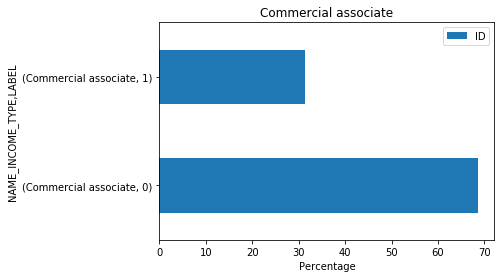

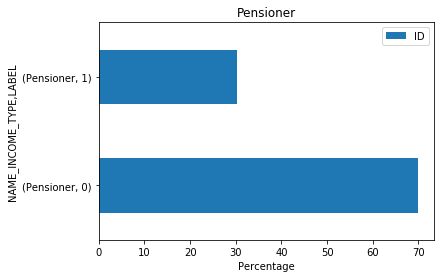

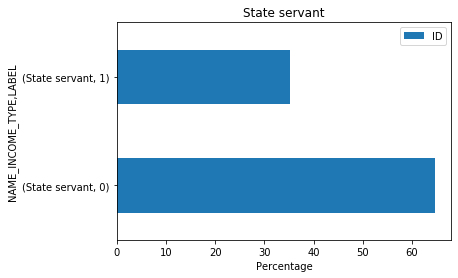

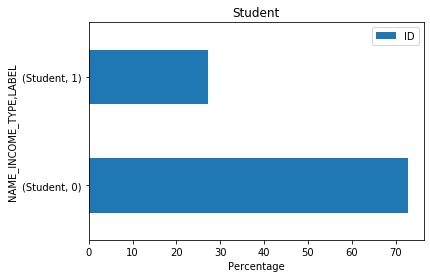

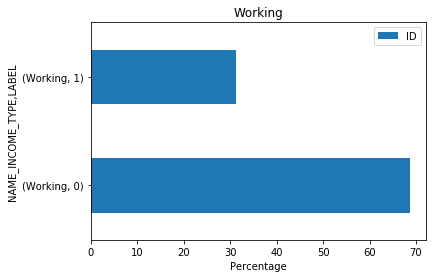

In [648]:
percentagePlot(dfCredit,'NAME_INCOME_TYPE')

In [649]:
tempDf = dfCredit[['ID','NAME_INCOME_TYPE','LABEL']]
(tempDf.groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(dfCredit))*100

ID
NAME_INCOME_TYPE     LABEL           
Commercial associate 0      16.233819
                     1       7.392331
Pensioner            0      11.239111
                     1       4.860376
State servant        0       5.560531
                     1       3.024505
Student              0       0.032565
                     1       0.012212
Working              0      35.455508
                     1      16.189042

In [650]:
(tempDf[tempDf['NAME_INCOME_TYPE']=='Working'].groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_INCOME_TYPE']=='Working']))*100

ID
NAME_INCOME_TYPE LABEL           
Working          0      68.652952
                 1      31.347048

In [651]:
(tempDf[tempDf['NAME_INCOME_TYPE']=='Commercial associate'].groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_INCOME_TYPE']=='Commercial associate']))*100

ID
NAME_INCOME_TYPE     LABEL           
Commercial associate 0      68.711234
                     1      31.288766

In [652]:
(tempDf[tempDf['NAME_INCOME_TYPE']=='Pensioner'].groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_INCOME_TYPE']=='Pensioner']))*100

ID
NAME_INCOME_TYPE LABEL           
Pensioner        0      69.810367
                 1      30.189633

In [653]:
(tempDf[tempDf['NAME_INCOME_TYPE']=='State servant'].groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_INCOME_TYPE']=='State servant']))*100

ID
NAME_INCOME_TYPE LABEL           
State servant    0      64.770033
                 1      35.229967

In [654]:
(tempDf[tempDf['NAME_INCOME_TYPE']=='Student'].groupby(['NAME_INCOME_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_INCOME_TYPE']=='Student']))*100

ID
NAME_INCOME_TYPE LABEL           
Student          0      72.727273
                 1      27.272727

* Majority of the customers income from Working 
* Customer income from State servant is more possibly to become a bad client followed by Working and Commercial associate
* A fraction of customers comes from Student, this should be interesting as the bank would approve student a credit, students good and bad ratio are better among the others 

### NAME_EDUCATION_TYPE

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

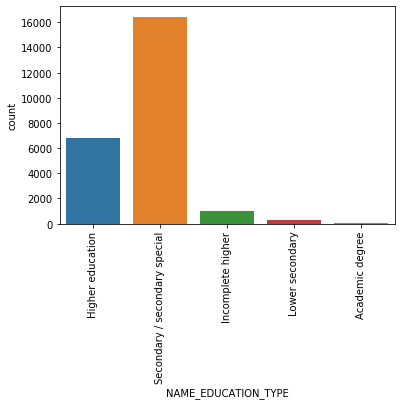

In [655]:
sns.countplot(dfCredit['NAME_EDUCATION_TYPE'])
plt.xticks(rotation='vertical')

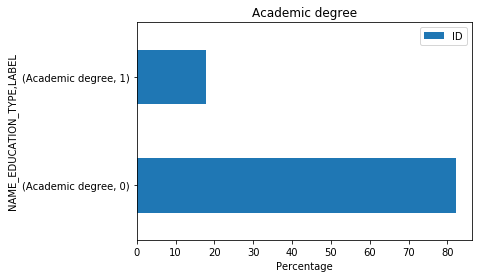

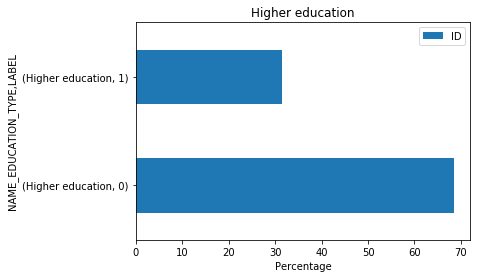

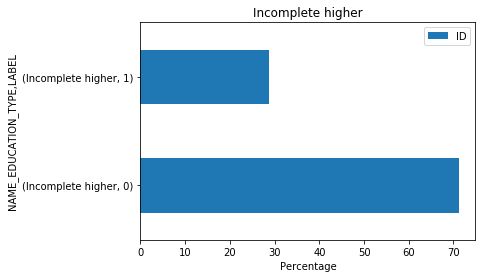

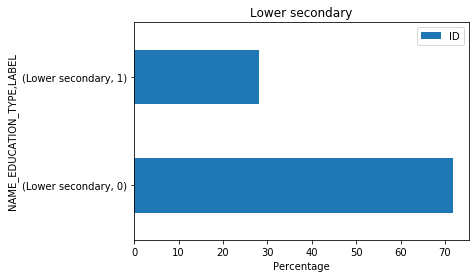

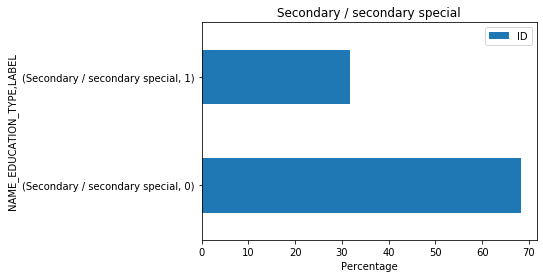

In [656]:
percentagePlot(dfCredit,'NAME_EDUCATION_TYPE')

In [657]:
tempDf = dfCredit[['ID','NAME_EDUCATION_TYPE','LABEL']]
(tempDf.groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(dfCredit))*100

ID
NAME_EDUCATION_TYPE           LABEL           
Academic degree               0       0.093625
                              1       0.020353
Higher education              0      19.083286
                              1       8.735651
Incomplete higher             0       2.833184
                              1       1.139787
Lower secondary               0       0.810063
                              1       0.317512
Secondary / secondary special 0      45.701376
                              1      21.265163

In [658]:
#Ratio
(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Higher education'].groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Higher education']))*100

ID
NAME_EDUCATION_TYPE LABEL           
Higher education    0      68.598186
                    1      31.401814

In [659]:
#Ratio
(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Incomplete higher'].groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Incomplete higher']))*100

ID
NAME_EDUCATION_TYPE LABEL           
Incomplete higher   0      71.311475
                    1      28.688525

In [660]:
#Ratio
(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Lower secondary'].groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Lower secondary']))*100

ID
NAME_EDUCATION_TYPE LABEL           
Lower secondary     0      71.841155
                    1      28.158845

In [661]:
#Ratio
(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Secondary / secondary special'].groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Secondary / secondary special']))*100

ID
NAME_EDUCATION_TYPE           LABEL           
Secondary / secondary special 0      68.245091
                              1      31.754909

In [662]:
#Ratio
(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Academic degree'].groupby(['NAME_EDUCATION_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_EDUCATION_TYPE']=='Academic degree']))*100

ID
NAME_EDUCATION_TYPE LABEL           
Academic degree     0      82.142857
                    1      17.857143

* The majority of the customers education is Secondary / secondary special
* Customer from Higher education and Secondary / secondary special are more likely to become a bad 
* Some of the customers got Academic degree, and not a single one is a bad client. The bank might consider into targeting more customer that got degree

### NAME_FAMILY_STATUS

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

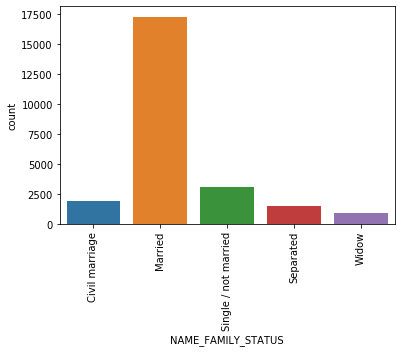

In [663]:
sns.countplot(dfCredit['NAME_FAMILY_STATUS'])
plt.xticks(rotation='vertical')

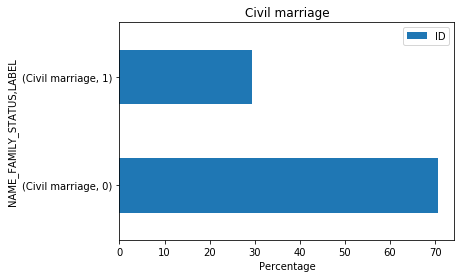

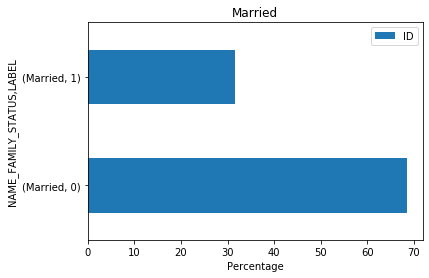

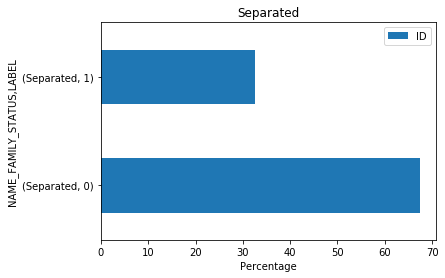

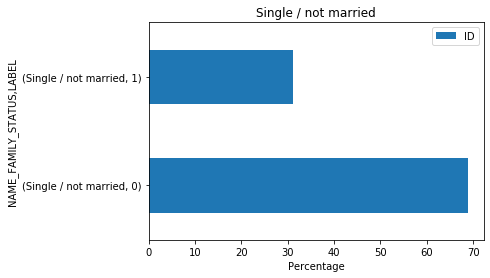

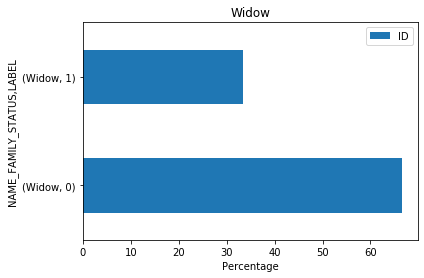

In [664]:
percentagePlot(dfCredit,'NAME_FAMILY_STATUS')

In [665]:
tempDf = dfCredit[['ID','NAME_FAMILY_STATUS','LABEL']]
(tempDf.groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(dfCredit))*100

ID
NAME_FAMILY_STATUS   LABEL           
Civil marriage       0       5.483188
                     1       2.271432
Married              0      48.086787
                     1      22.176993
Separated            0       3.977041
                     1       1.925425
Single / not married 0       8.462916
                     1       3.838639
Widow                0       2.511601
                     1       1.265977

In [666]:
#Ratio
(tempDf[tempDf['NAME_FAMILY_STATUS']=='Civil marriage'].groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(tempDf[tempDf['NAME_FAMILY_STATUS']=='Civil marriage']))*100

ID
NAME_FAMILY_STATUS LABEL           
Civil marriage     0      70.708661
                   1      29.291339

In [667]:
#Ratio
(tempDf[tempDf['NAME_FAMILY_STATUS']=='Married'].groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(tempDf[tempDf['NAME_FAMILY_STATUS']=='Married']))*100

ID
NAME_FAMILY_STATUS LABEL           
Married            0      68.437518
                   1      31.562482

In [668]:
#Ratio
(tempDf[tempDf['NAME_FAMILY_STATUS']=='Separated'].groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(tempDf[tempDf['NAME_FAMILY_STATUS']=='Separated']))*100

ID
NAME_FAMILY_STATUS LABEL          
Separated          0      67.37931
                   1      32.62069

In [669]:
#Ratio
(tempDf[tempDf['NAME_FAMILY_STATUS']=='Single / not married'].groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(tempDf[tempDf['NAME_FAMILY_STATUS']=='Single / not married']))*100

ID
NAME_FAMILY_STATUS   LABEL         
Single / not married 0      68.7955
                     1      31.2045

In [670]:
#Ratio
(tempDf[tempDf['NAME_FAMILY_STATUS']=='Widow'].groupby(['NAME_FAMILY_STATUS','LABEL']).agg('count')/len(tempDf[tempDf['NAME_FAMILY_STATUS']=='Widow']))*100

ID
NAME_FAMILY_STATUS LABEL           
Widow              0      66.487069
                   1      33.512931

* Family status mostly married
* Customer that are Widow tend to be a bad client, the bank might add more precaution for widow

### NAME_HOUSING_TYPE

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

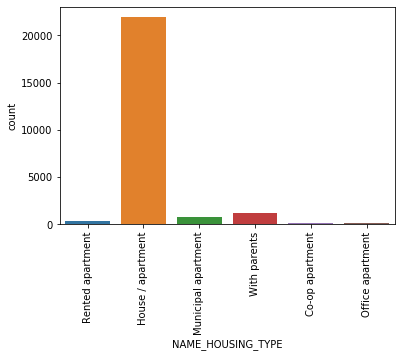

In [671]:
sns.countplot(dfCredit['NAME_HOUSING_TYPE'])
plt.xticks(rotation='vertical')

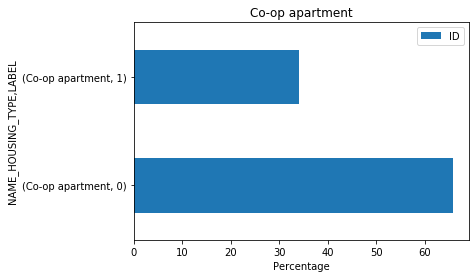

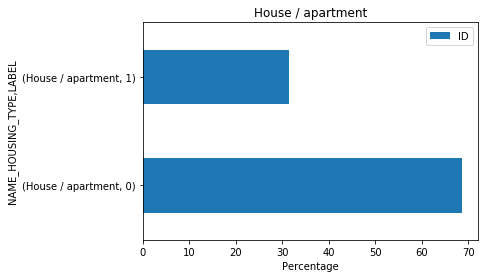

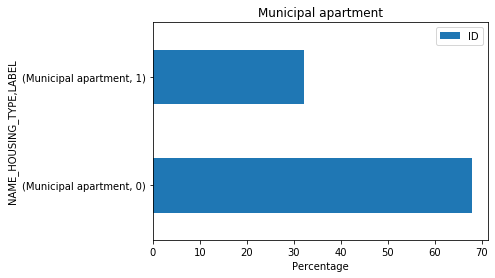

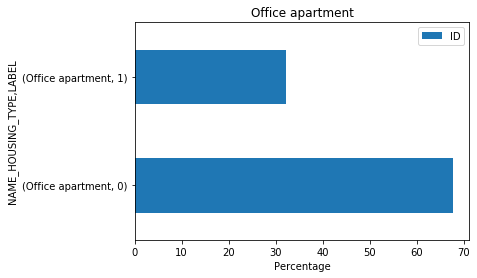

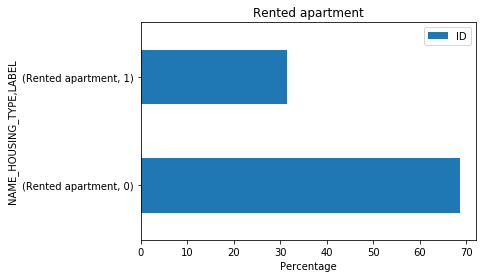

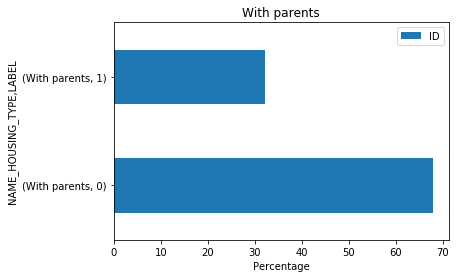

In [672]:
percentagePlot(dfCredit,'NAME_HOUSING_TYPE')

In [673]:
tempDf = dfCredit[['ID','NAME_HOUSING_TYPE','LABEL']]
(tempDf.groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(dfCredit))*100

ID
NAME_HOUSING_TYPE   LABEL           
Co-op apartment     0       0.313441
                    1       0.162827
House / apartment   0      61.218758
                    1      28.022470
Municipal apartment 0       2.190019
                    1       1.033949
Office apartment    0       0.488480
                    1       0.232028
Rented apartment    0       0.997313
                    1       0.455915
With parents        0       3.313523
                    1       1.571277

In [674]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='Co-op apartment'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='Co-op apartment']))*100

ID
NAME_HOUSING_TYPE LABEL           
Co-op apartment   0      65.811966
                  1      34.188034

In [675]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='House / apartment'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='House / apartment']))*100

ID
NAME_HOUSING_TYPE LABEL           
House / apartment 0      68.599188
                  1      31.400812

In [676]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='Municipal apartment'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='Municipal apartment']))*100

ID
NAME_HOUSING_TYPE   LABEL           
Municipal apartment 0      67.929293
                    1      32.070707

In [677]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='Office apartment'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='Office apartment']))*100

ID
NAME_HOUSING_TYPE LABEL          
Office apartment  0      67.79661
                  1      32.20339

In [678]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='Rented apartment'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='Rented apartment']))*100

ID
NAME_HOUSING_TYPE LABEL           
Rented apartment  0      68.627451
                  1      31.372549

In [679]:
#Ratio
(tempDf[tempDf['NAME_HOUSING_TYPE']=='With parents'].groupby(['NAME_HOUSING_TYPE','LABEL']).agg('count')/len(tempDf[tempDf['NAME_HOUSING_TYPE']=='With parents']))*100

ID
NAME_HOUSING_TYPE LABEL           
With parents      0      67.833333
                  1      32.166667

* Customers mainly lived in a house or apartment 
* Customer lived in Co-op apartment is more likely to become a bad client 

### FLAG_MOBIL

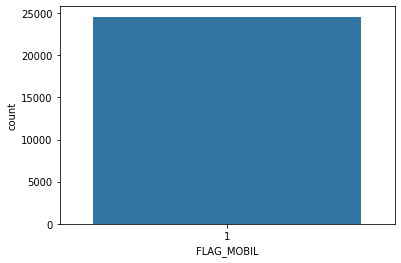

In [680]:
sns.countplot(dfCredit['FLAG_MOBIL'])

* All of customers has mobile phone thus this feature will dropped

### FLAG_WORK_PHONE

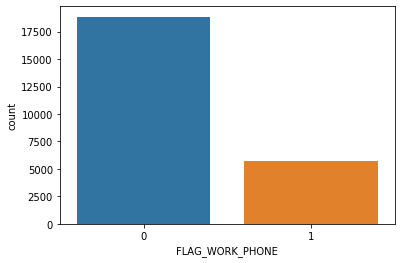

In [681]:
sns.countplot(dfCredit['FLAG_WORK_PHONE'])

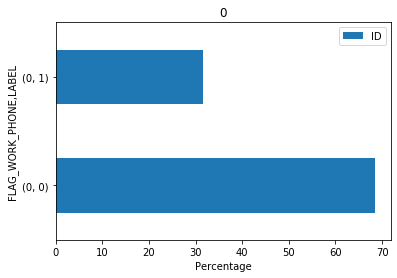

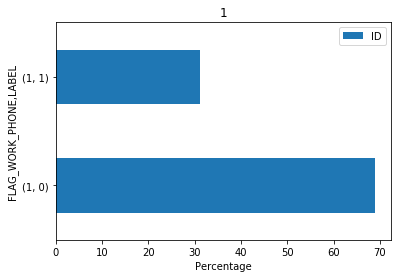

In [682]:
percentagePlot(dfCredit,'FLAG_WORK_PHONE')

In [683]:
tempDf = dfCredit[['ID','FLAG_WORK_PHONE','LABEL']]
(tempDf.groupby(['FLAG_WORK_PHONE','LABEL']).agg('count')/len(dfCredit))*100

ID
FLAG_WORK_PHONE LABEL           
0               0      52.491248
                1      24.240821
1               0      16.030286
                1       7.237646

In [684]:
#Ratio
(tempDf[tempDf['FLAG_WORK_PHONE']==0].groupby(['FLAG_WORK_PHONE','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_WORK_PHONE']==0]))*100

ID
FLAG_WORK_PHONE LABEL           
0               0      68.408488
                1      31.591512

In [685]:
#Ratio
(tempDf[tempDf['FLAG_WORK_PHONE']==1].groupby(['FLAG_WORK_PHONE','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_WORK_PHONE']==1]))*100

ID
FLAG_WORK_PHONE LABEL           
1               0      68.894332
                1      31.105668

* Customer mostly do not have a work phone
* No significant sign this feature affect the target

### FLAG_PHONE

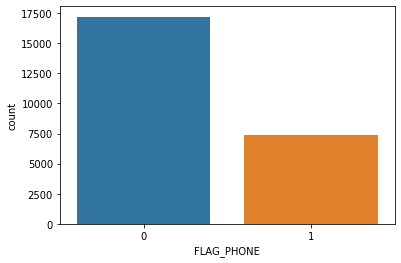

In [686]:
sns.countplot(dfCredit['FLAG_PHONE'])

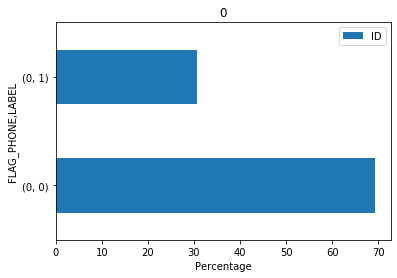

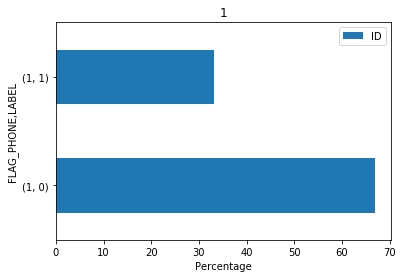

In [687]:
percentagePlot(dfCredit,'FLAG_PHONE')

In [688]:
tempDf = dfCredit[['ID','FLAG_PHONE','LABEL']]
(tempDf.groupby(['FLAG_PHONE','LABEL']).agg('count')/len(dfCredit))*100

ID
FLAG_PHONE LABEL           
0          0      48.424652
           1      21.525686
1          0      20.096882
           1       9.952780

In [689]:
#Ratio
(tempDf[tempDf['FLAG_PHONE']==0].groupby(['FLAG_PHONE','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_PHONE']==0]))*100

ID
FLAG_PHONE LABEL           
0          0      69.227188
           1      30.772812

In [690]:
#Ratio
(tempDf[tempDf['FLAG_PHONE']==1].groupby(['FLAG_PHONE','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_PHONE']==1]))*100

ID
FLAG_PHONE LABEL           
1          0      66.878895
           1      33.121105

* Customer mostly do not have a phone/ landline
* Customers with a landline slighly more to be bad client

### FLAG_EMAIL

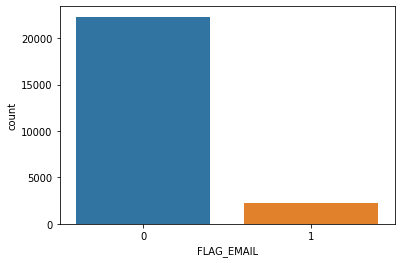

In [691]:
sns.countplot(dfCredit['FLAG_EMAIL'])

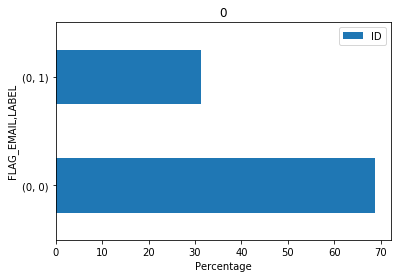

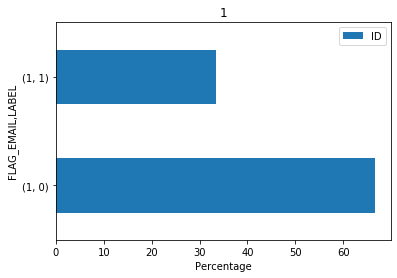

In [692]:
percentagePlot(dfCredit,'FLAG_EMAIL')

In [693]:
tempDf = dfCredit[['ID','FLAG_EMAIL','LABEL']]
(tempDf.groupby(['FLAG_EMAIL','LABEL']).agg('count')/len(dfCredit))*100

ID
FLAG_EMAIL LABEL           
0          0      62.403322
           1      28.405113
1          0       6.118212
           1       3.073353

In [694]:
#Ratio
(tempDf[tempDf['FLAG_EMAIL']==0].groupby(['FLAG_EMAIL','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_EMAIL']==0]))*100

ID
FLAG_EMAIL LABEL           
0          0      68.719742
           1      31.280258

In [695]:
#Ratio
(tempDf[tempDf['FLAG_EMAIL']==1].groupby(['FLAG_EMAIL','LABEL']).agg('count')/len(tempDf[tempDf['FLAG_EMAIL']==1]))*100

ID
FLAG_EMAIL LABEL          
1          0      66.56333
           1      33.43667

* Customer mostly do not email address
* Customer that has email address slightly more to be a bad client

## Continous Feature

### CNT_CHILDREN

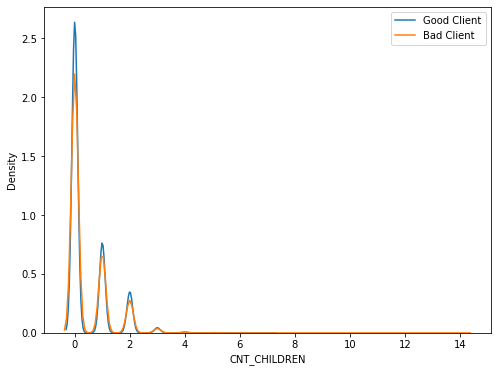

In [696]:
plt.figure(figsize=(8,6))
sns.kdeplot(dfCredit[(dfCredit['LABEL']==0)]['CNT_CHILDREN'],label='Good Client')
sns.kdeplot(dfCredit[(dfCredit['LABEL']==1)]['CNT_CHILDREN'],label='Bad Client')
plt.legend()

* Customers mainly do not have children
* No significant sign this feature affect the target

### AMT_INCOME_TOTAL

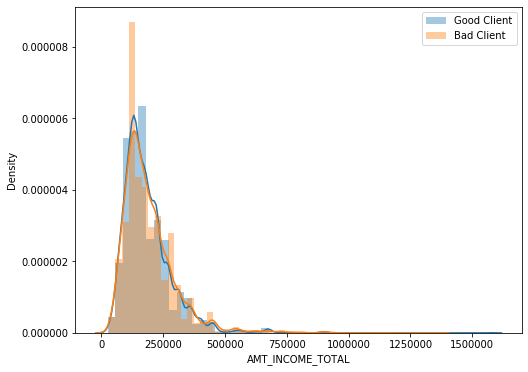

In [697]:
plt.figure(figsize=(8,6))
sns.distplot(dfCredit[(dfCredit['LABEL']==0)]['AMT_INCOME_TOTAL'],label='Good Client')
sns.distplot(dfCredit[(dfCredit['LABEL']==1)]['AMT_INCOME_TOTAL'],label='Bad Client')
plt.legend()

* Customers mainly have low income
* No significant sign this feature affect the target

### DAYS_BIRTH

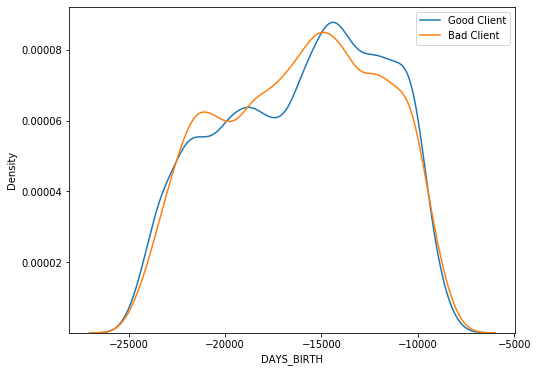

In [698]:
plt.figure(figsize=(8,6))
sns.kdeplot(dfCredit[(dfCredit['LABEL']==0)]['DAYS_BIRTH'],label='Good Client')
sns.kdeplot(dfCredit[(dfCredit['LABEL']==1)]['DAYS_BIRTH'],label='Bad Client')
plt.legend()


In [699]:
tempAge = pd.DataFrame(dfCredit['DAYS_BIRTH'].apply(lambda x: x*-1//360).reset_index(drop=True))
tempAge['LABEL'] = dfCredit['LABEL'].reset_index(drop=True)

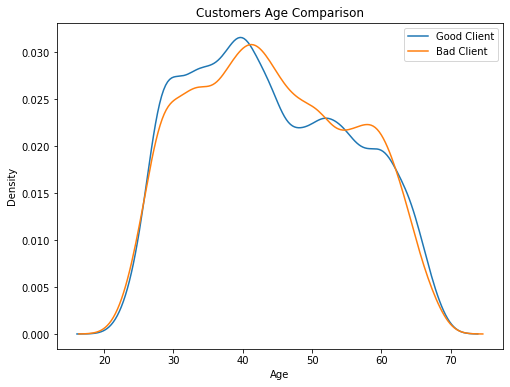

In [856]:
plt.figure(figsize=(8,6))
plt.title('Customers Age Comparison')
sns.kdeplot(tempAge[(tempAge['LABEL']==0)]['DAYS_BIRTH'],label='Good Client')
sns.kdeplot(tempAge[(tempAge['LABEL']==1)]['DAYS_BIRTH'],label='Bad Client')
plt.xlabel('Age')
plt.legend()
plt.savefig('C:\\Users\\Aris\\Documents\\Jupyter Purwa\\Final Project\\Dashboard\\static\\age.png')

* Customers aged above 40 most likely to be a bad client
* While younger customer from 25-40 will most likely a good client
* This feature could be binned into 5 categories: Young,Young Adult, Adult, Old, Seniors

### DAYS_EMPLOYED

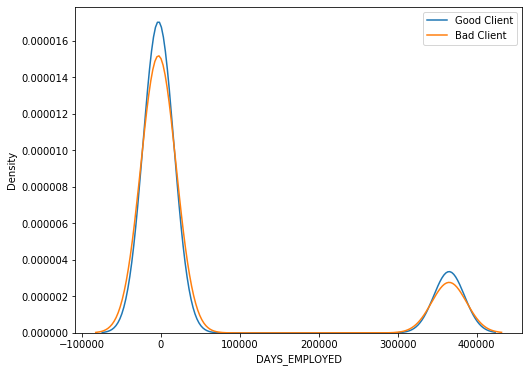

In [701]:
plt.figure(figsize=(8,6))
sns.kdeplot(dfCredit[(dfCredit['LABEL']==0)]['DAYS_EMPLOYED'],label='Good Client')
sns.kdeplot(dfCredit[(dfCredit['LABEL']==1)]['DAYS_EMPLOYED'],label='Bad Client')
plt.legend()

So there are people that are employed and unemployed, lets try to separate them

In [702]:
tempEmployed = pd.DataFrame(dfCredit[dfCredit['DAYS_EMPLOYED']>0]['DAYS_EMPLOYED'].apply(lambda x: x//360).reset_index(drop=True),columns=['DAYS_EMPLOYED'])
tempEmployed['LABEL'] = dfCredit[dfCredit['DAYS_EMPLOYED']>0]['LABEL'].reset_index(drop=True)
tempEmployed.head()

,DAYS_EMPLOYED,LABEL
0,1014,1
1,1014,1
2,1014,1
3,1014,0
4,1014,1


Unemployed for 1014 years? that doesn't make sense

In [703]:
dfCredit[dfCredit['DAYS_EMPLOYED']>0][['NAME_INCOME_TYPE','DAYS_EMPLOYED']].head()

,NAME_INCOME_TYPE,DAYS_EMPLOYED
7,Pensioner,365243
8,Pensioner,365243
9,Pensioner,365243
76,Pensioner,365243
161,Pensioner,365243


In [704]:
np.unique(dfCredit[dfCredit['DAYS_EMPLOYED']>0][['NAME_INCOME_TYPE']])

array(['Pensioner'], dtype=object)

Turns out it was for the pensioner, and there are no customer that currently unemployed

In [705]:
tempEmployed = pd.DataFrame(dfCredit[dfCredit['DAYS_EMPLOYED']<0]['DAYS_EMPLOYED'].apply(lambda x: (x*-1)//360).reset_index(drop=True),columns=['DAYS_EMPLOYED'])
tempEmployed['LABEL'] = dfCredit[dfCredit['DAYS_EMPLOYED']<0]['LABEL'].reset_index(drop=True)
tempEmployed.head()

,DAYS_EMPLOYED,LABEL
0,12,0
1,12,0
2,3,0
3,8,0
4,8,0


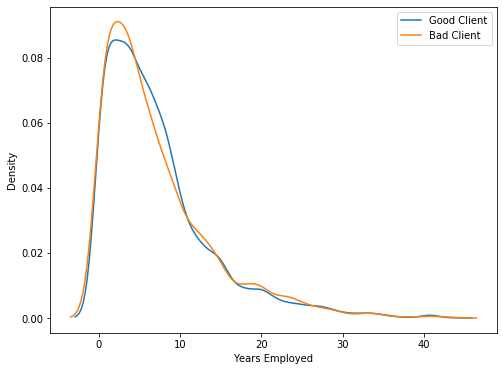

In [337]:
plt.figure(figsize=(8,6))
sns.kdeplot(tempEmployed[(tempEmployed['LABEL']==0)]['DAYS_EMPLOYED'],label='Good Client')
sns.kdeplot(tempEmployed[(tempEmployed['LABEL']==1)]['DAYS_EMPLOYED'],label='Bad Client')
plt.xlabel('Years Employed')
plt.legend()

In [706]:
tempDay=pd.DataFrame(dfCredit['ID'])

In [707]:
tempDay['DAYS_EMPLOYED']  = pd.DataFrame(np.where(dfCredit['DAYS_EMPLOYED']<0,'Employed','Pensioner'))
tempDay['LABEL'] = dfCredit['LABEL'].reset_index(drop=True)
tempDay['ID'] = dfCredit['ID'].reset_index(drop=True)

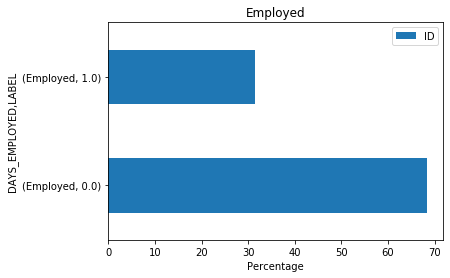

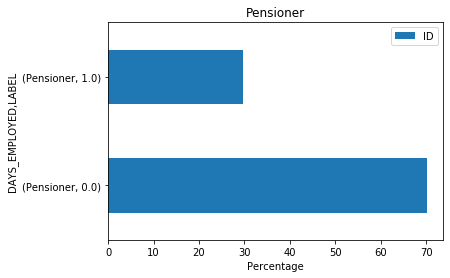

In [708]:
percentagePlot(tempDay,'DAYS_EMPLOYED')

In [709]:
tempDf = tempDay[['ID','DAYS_EMPLOYED','LABEL']]
(tempDf.groupby(['DAYS_EMPLOYED','LABEL']).agg('count')/len(dfCredit))*100

ID
DAYS_EMPLOYED LABEL           
Employed      0.0    29.284377
              1.0    13.510543
Pensioner     0.0     5.780347
              1.0     2.450541

In [710]:
#Ratio
(tempDf[tempDf['DAYS_EMPLOYED']=='Employed'].groupby(['DAYS_EMPLOYED','LABEL']).agg('count')/len(tempDf[tempDf['DAYS_EMPLOYED']=='Employed']))*100

ID
DAYS_EMPLOYED LABEL           
Employed      0.0    68.429563
              1.0    31.570437

In [711]:
#Ratio
(tempDf[tempDf['DAYS_EMPLOYED']=='Pensioner'].groupby(['DAYS_EMPLOYED','LABEL']).agg('count')/len(tempDf[tempDf['DAYS_EMPLOYED']=='Pensioner']))*100

ID
DAYS_EMPLOYED LABEL           
Pensioner     0.0    70.227498
              1.0    29.772502

* The majority of the customers are employed
* Employed customers are the ones who most likely to be a bad client
* We'll try to divide this feature into 5 categories: Entry Level, Junior, Senior, Expert, Pensioner

### CNT_FAM_MEMBERS

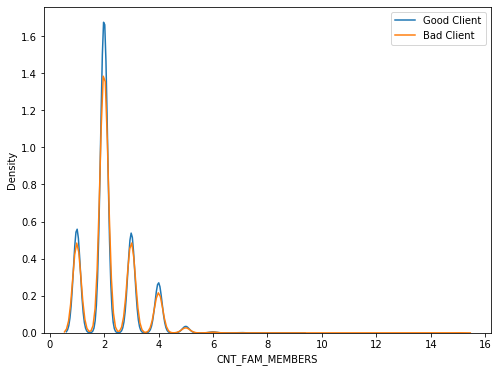

In [712]:
plt.figure(figsize=(8,6))
sns.kdeplot(dfCredit[(dfCredit['LABEL']==0)]['CNT_FAM_MEMBERS'],label='Good Client')
sns.kdeplot(dfCredit[(dfCredit['LABEL']==1)]['CNT_FAM_MEMBERS'],label='Bad Client')
plt.legend()

* Based on the graph, Family Members doesn't really affect the target
* We'll also could categorize this feature into 3 categories: Small family, Medium Family, Large family

### Summary

CATEGORICAL:<br>
* <b>CODE_GENDER:</b> Most of the customers are Female and no significant affect to target (can be dropped)
* <b>FLAG_OWN_REALTY:</b> Majority own a property and customer that doesn't own property is more likely a bad client
* <b>NAME_INCOME_TYPE:</b> Customers income mainly from working and income from State Servant more likely to become bad client
* <b>NAME_EDUCATION_TYPE:</b> Customers mainly come from Secondary/Secondary Special and Higher education and Secondary / secondary special are more likely to become a bad  client
* <b>NAME_FAMILY_STATUS:</b> Mostly married, Customer that are Widow tend to be a bad client, the bank might add more precaution for widow
* <b>NAME_HOUSING_TYPE:</b> Mostly lived in a house / apartment and most bad client came from Co-op apartment
* <b>FLAG_MOBIL:</b> This feature will be dropped since all customers have mobile phone
* <b>FLAG_WORK_PHONE:</b> Mostly don't have work phone and no significant sign it affect the target (might be dropped)
* <b>FLAG_PHONE:</b> Mostly don't have phone/landline and Customers with a landline slighly more to be bad client
* <b>FLAG_EMAIL:</b> Most of the customers do not have email address, and the one who have most likely to be bad client
<br><br>

CONTINUOUS:<br>
* <b>CNT_CHILDREN:</b> Mainly do not have child and no significant sign it affect the target (might be dropped), could be split into several categories (No child, Few children, Many children)
* <b>AMT_INCOME_TOTAL:</b> Mostly low income and no significant sign it affect the target (might be dropped),  could be split into several categories (Low Income, Medium Income, High Income)
* <b>DAYS_BIRTH:</b> Customers older than 40 tend to be bad client, could be split into several categories (Young, Young Adult, Adult, Old, Seniors)
* <b>DAYS_EMPLOYED:</b> Mostly employed and has been working for around 5 years and Employed customers are the ones who most likely to be a bad client, could be split into several categories (Entry Level, Junior, Senior, Expert, Pensioner)
* <b>CNT_FAM_MEMBERS:</b> Mainly have 2 family members and no significant sign it affect the target (might be dropped),  could be split into several categories (Small family, Medium family, Large family)
<br><br>


ACTION PLAN:<br>
* Drop FLAG_MOBIL<br>
* (Optional) Drop CODE_GENDER,FLAG_WORK_PHONE,CNT_CHILDREN,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS, if result isn't good<br>
* Encode: <br>
1 Manually Encode: FLAG_OWN_CAR, FLAG_OWN_CAR<br>
2 One Hot: CODE_GENDER<br>
3 Binary: NAME_INCOME_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE<br>
4 Ordinal: NAME_EDUCATION_TYPE<br>
* Drop feature that shows correlation<br>
* Drop outlier<br>

# Feature Engineering

In [719]:
#Dropping Flag Mobile
dfCreditClean=dfCredit.drop('FLAG_MOBIL',axis=1)
dfCreditClean.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,LABEL
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,2.0,0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,1.0,0


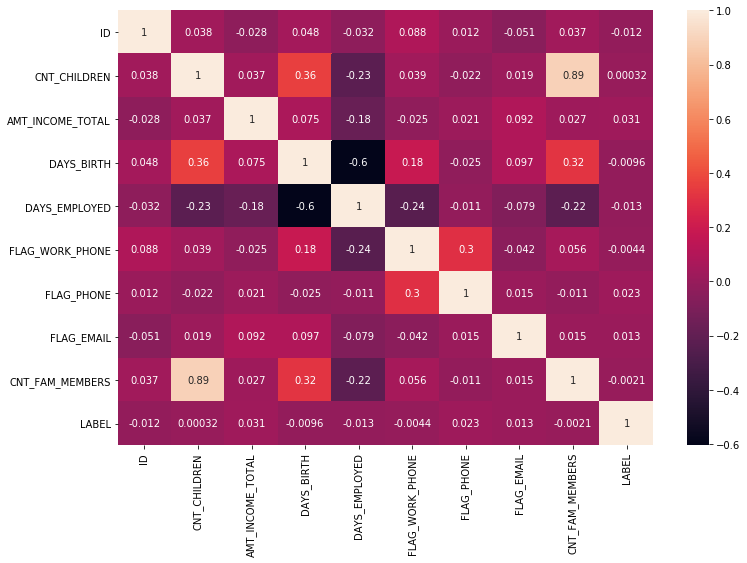

In [720]:
plt.figure(figsize=(12,8))
sns.heatmap(dfCreditClean.corr(),annot=True)

* Found high postive correlation between CNT_CHILDREN and CNT_FAM_MEMBERS 
* Found high negative correlation between DAYS_BIRTH and DAYS_EMPLOYED (Will drop DAYS_EMPLOYED)
* Found low positive correlation between DAYS_BIRTH and CNT_CHILDREN (Will drop CNT_CHILDREN)
* Found low positive correlation between DAYS_BIRTH and CNT_FAM_MEMBERS (Will drop CNT_FAM_MEMBERS)
* Found low positive correlation between FLAG_WORK_PHONE and FLAG_PHONE (Will drop FLAG_WORK_PHONE)

In [721]:
dfCreditClean = dfCreditClean.drop(['CNT_FAM_MEMBERS','DAYS_EMPLOYED','FLAG_WORK_PHONE','CNT_CHILDREN'],axis=1).reset_index(drop=True)
dfCreditClean.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_PHONE,FLAG_EMAIL,LABEL
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,0,0,0
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,0,0,0
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,0,0,0
3,5008810,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,1,1,0
4,5008811,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,1,1,0


In [722]:
#Convert FLAG_OWN_CAR and FLAG_OWN_REALTY into 1 and 0
dfCreditClean['FLAG_OWN_CAR'] = np.where(dfCreditClean['FLAG_OWN_CAR']=='Y',1,0)
dfCreditClean['FLAG_OWN_REALTY'] = np.where(dfCreditClean['FLAG_OWN_REALTY']=='Y',1,0)
#Convert DAYS_BIRTH into year period
dfCreditClean['DAYS_BIRTH'] = dfCreditClean['DAYS_BIRTH'].apply(lambda x: x*-1//360)
dfCreditClean.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_PHONE,FLAG_EMAIL,LABEL
0,5008804,M,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,33,0,0,0
1,5008805,M,1,1,427500.0,Working,Higher education,Civil marriage,Rented apartment,33,0,0,0
2,5008806,M,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,59,0,0,0
3,5008810,F,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,1,1,0
4,5008811,F,0,1,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,1,1,0


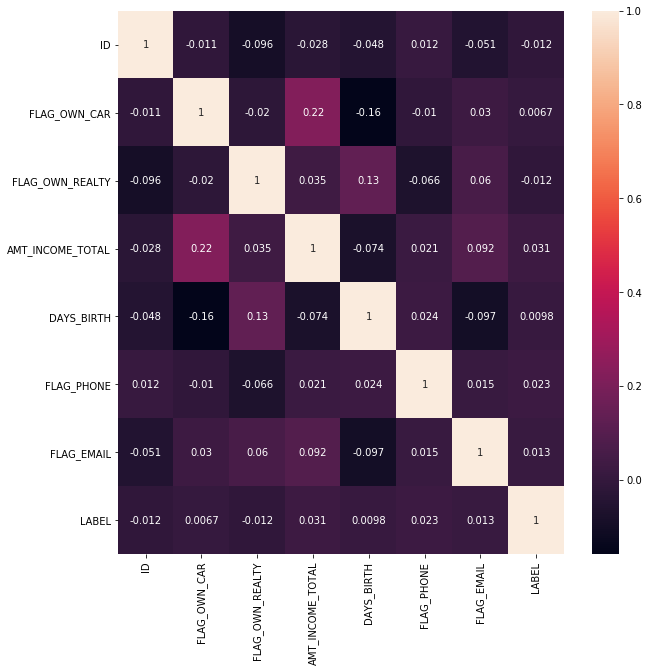

In [723]:
plt.figure(figsize=(10,10))
sns.heatmap(dfCreditClean.corr(),annot=True)

In [724]:
dfCreditClean['LABEL'].value_counts(normalize=True)

0    0.685215
1    0.314785
Name: LABEL, dtype: float64

In [725]:
len(dfCreditClean)

24566

# Pre-process and Model Benchmark

MODEL USED:
* Logistic Regression
* Random Forest 
* Decision Tree
* SVM
* KNN
* XGB

Balancer:
* SMOTE
* NearMiss
* RandomOverSample
* RandomUnderSample

Scaling:
* Standar Scaler (replace by Robust Scaler if any outlier found)

POLYNOMIAL

ENCODING:
* One Hot: CODE_GENDER
* Binary: NAME_INCOME_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE
* Ordinal: NAME_EDUCATION_TYPE

#### Detect Outlier

In [726]:
dfCreditClean.describe(include='number').columns

Index(['ID', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL',
       'DAYS_BIRTH', 'FLAG_PHONE', 'FLAG_EMAIL', 'LABEL'],
      dtype='object')

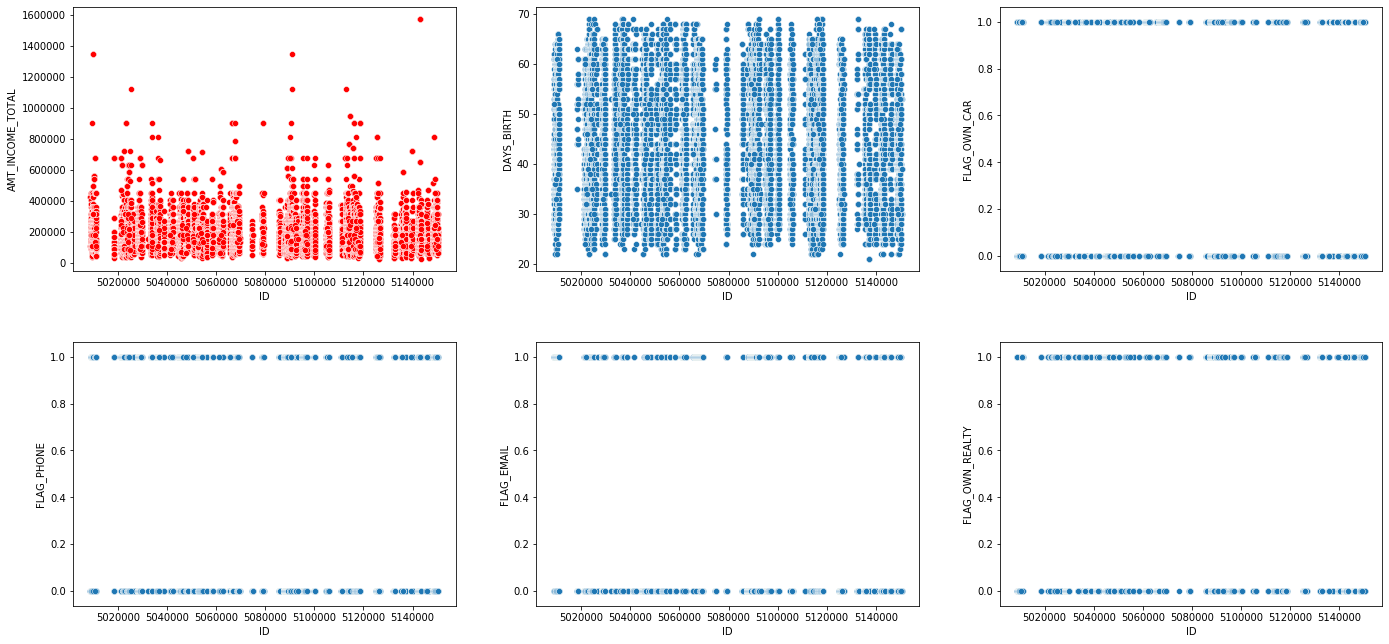

In [733]:
fig, ax= plt.subplots(2, 3, figsize= (20,10))
fig.tight_layout(pad=5.0)
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=dfCreditClean, ax=ax[0][0],color= 'r')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=dfCreditClean, ax=ax[0][1])
sns.scatterplot(x='ID', y='FLAG_OWN_CAR', data=dfCreditClean, ax=ax[0][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=dfCreditClean, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=dfCreditClean, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_OWN_REALTY', data=dfCreditClean, ax=ax[1][2])

There's an outlier in AMT_INCOME_TOTAL

In [734]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = dfCreditClean['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = dfCreditClean['AMT_INCOME_TOTAL'].quantile(0.001)
dfCreditClean= dfCreditClean[(dfCreditClean['AMT_INCOME_TOTAL']>q_low) & (dfCreditClean['AMT_INCOME_TOTAL']<q_hi)]

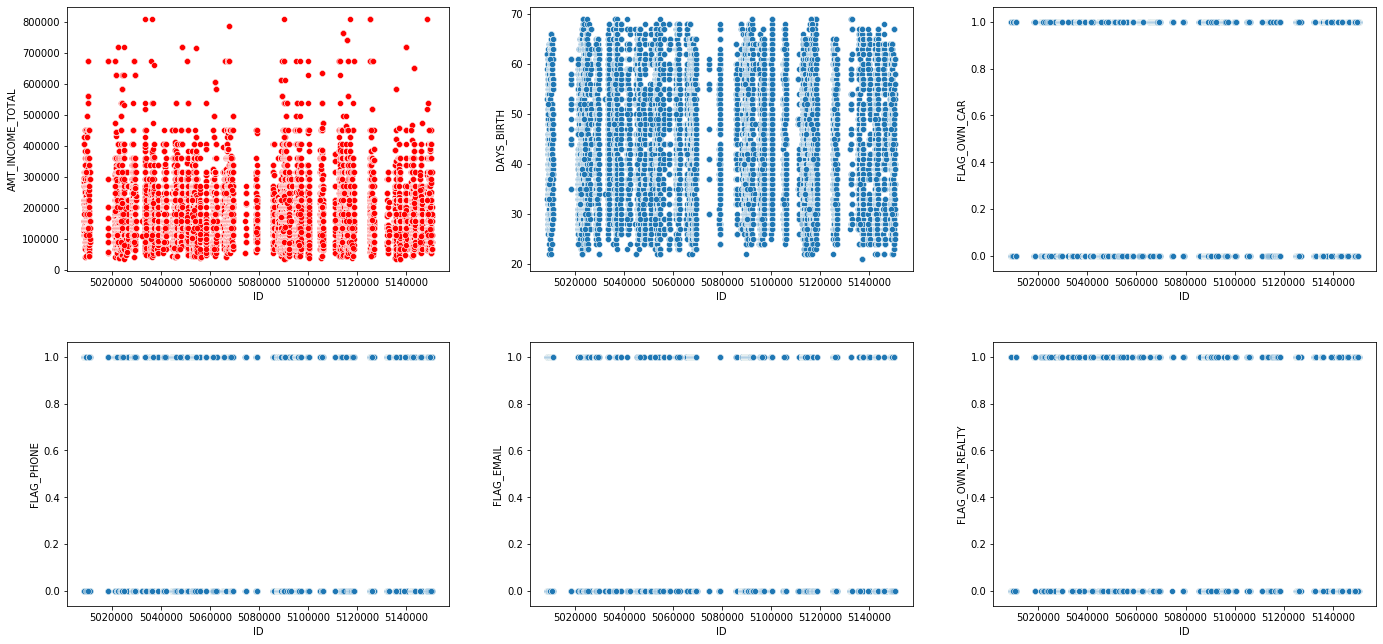

In [736]:
fig, ax= plt.subplots(2, 3, figsize= (20,10))
fig.tight_layout(pad=5.0)
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=dfCreditClean, ax=ax[0][0],color= 'r')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=dfCreditClean, ax=ax[0][1])
sns.scatterplot(x='ID', y='FLAG_OWN_CAR', data=dfCreditClean, ax=ax[0][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=dfCreditClean, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=dfCreditClean, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_OWN_REALTY', data=dfCreditClean, ax=ax[1][2])

Data seems more tidier

#### Data Splitting

In [759]:
X = dfCreditClean.drop(['LABEL','ID'],axis=1)
y = dfCreditClean['LABEL']

In [760]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=2021)

#### Column Transformer and Pipeline

In [761]:
ordinal_mapping=[{'col':'NAME_EDUCATION_TYPE','mapping':{'Lower secondary':1,'Secondary / secondary special':2,'Incomplete higher':3,'Higher education':4,'Academic degree':5}}]
ordinal_encoder = ce.OrdinalEncoder(mapping=ordinal_mapping)

In [762]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

In [763]:
transformer =ColumnTransformer([
    ('ordinal',ordinal_encoder,['NAME_EDUCATION_TYPE']),
    ('onehot',OneHotEncoder(drop='first'),['CODE_GENDER']),
    ('binary',ce.BinaryEncoder(),['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']),
    ('scaling',StandardScaler(),['AMT_INCOME_TOTAL', 'DAYS_BIRTH']),
    ('poly',poly,['AMT_INCOME_TOTAL', 'DAYS_BIRTH']),
],remainder='passthrough')
transformer.fit_transform(X)

array([[4., 1., 0., ..., 1., 0., 0.],
       [4., 1., 0., ..., 1., 0., 0.],
       [2., 1., 0., ..., 1., 0., 0.],
       ...,
       [4., 0., 0., ..., 1., 1., 1.],
       [4., 0., 0., ..., 1., 1., 1.],
       [2., 1., 0., ..., 1., 0., 0.]])

#### Cross Validation

In [764]:
def scoringBalancing(models,transformer,balancing):
    skfold = StratifiedKFold(n_splits=5)
    df = pd.DataFrame(columns=['Name','Balancing','1','2','3','4','5','mean','std'])
    for i in models:
        for j in balancing:
            estimator = ImbPipe([
                ('transformer',transformer),
                ('balancing',j),
                ('model',i)
            ])
            arr = cross_val_score(estimator, X_train, y_train, scoring='average_precision',cv=skfold)
            df = df.append({'Name':str(estimator[-1]),'Balancing':str(estimator[-2]), '1':arr[0], '2':arr[1], '3':arr[2], '4':arr[3], '5':arr[4], 'mean':arr.mean(),'std':arr.std()}, ignore_index=True)
    return df.sort_values('mean',ascending=False)

In [765]:
#Models
logreg = LogisticRegression(max_iter=300,class_weight='balanced')
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(max_depth=3,max_features=5,n_jobs=-1,random_state=2021,class_weight='balanced')
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False)
svm = SVC(class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=3)
models = [rf,logreg,knn,svm,xgb,tree]

#Balancer
balancing = [NearMiss(),SMOTE(random_state=2021),RandomOverSampler(random_state=2021),RandomUnderSampler(random_state=2021)]
# poly = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)

In [766]:
import warnings
warnings.filterwarnings('ignore')

In [767]:
scoringBalancing(models,transformer,balancing)

[23:37:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Name,Balancing,1,2,3,4,5,mean,std
17,"XGBClassifier(base_score=None, booster=None, c...",SMOTE(random_state=2021),0.454603,0.426173,0.471770,0.458554,0.453565,0.452933,0.014871
18,"XGBClassifier(base_score=None, booster=None, c...",RandomOverSampler(random_state=2021),0.448622,0.420707,0.463860,0.472316,0.443573,0.449816,0.017839
19,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(random_state=2021),0.430061,0.401159,0.441044,0.425015,0.425038,0.424464,0.013038
9,KNeighborsClassifier(n_jobs=-1),SMOTE(random_state=2021),0.368667,0.355900,0.365546,0.353076,0.347458,0.358129,0.007880
10,KNeighborsClassifier(n_jobs=-1),RandomOverSampler(random_state=2021),0.350518,0.350941,0.365295,0.366970,0.346974,0.356140,0.008292
3,RandomForestClassifier(class_weight='balanced'...,RandomUnderSampler(random_state=2021),0.354841,0.330003,0.360272,0.354661,0.364256,0.352807,0.011953
2,RandomForestClassifier(class_weight='balanced'...,RandomOverSampler(random_state=2021),0.357561,0.328435,0.355767,0.354774,0.350020,0.349312,0.010732
11,KNeighborsClassifier(n_jobs=-1),RandomUnderSampler(random_state=2021),0.369010,0.340964,0.345907,0.344602,0.345706,0.349238,0.010045
16,"XGBClassifier(base_score=None, booster=None, c...",NearMiss(),0.340663,0.321757,0.341084,0.342041,0.362678,0.341645,0.012956
0,RandomForestClassifier(class_weight='balanced'...,NearMiss(),0.335097,0.319494,0.331765,0.339082,0.351222,0.335332,0.010298


We'll continue with XGb pair with SMOTE because it has highest score and good stability

#### Binning/Categorize

In [769]:
np.unique(pd.cut(dfCreditClean['AMT_INCOME_TOTAL'],3))

array([Interval(35226.0, 294000.0, closed='right'),
       Interval(294000.0, 552000.0, closed='right'),
       Interval(552000.0, 810000.0, closed='right')], dtype=object)

In [770]:
np.unique(pd.cut(dfCreditClean['DAYS_BIRTH'],5))

array([Interval(20.952, 30.6, closed='right'),
       Interval(30.6, 40.2, closed='right'),
       Interval(40.2, 49.8, closed='right'),
       Interval(49.8, 59.4, closed='right'),
       Interval(59.4, 69.0, closed='right')], dtype=object)

In [771]:
def binIncome(x):
    if x < 300000:
        return 'Low Income'
    elif x < 550000:
        return 'Medium Income'
    else:
        return 'High Income'
def binBirth(x):
    if x < 30:
        return 'Young Adult'
    elif x < 40:
        return 'Adult'
    elif x < 50:
        return 'Old Adult'
    elif x < 60:
        return 'Old'
    else:
        return 'Seniors'

In [772]:
dfCreditCleanBin = dfCreditClean.copy()

In [773]:
dfCreditCleanBin['AMT_INCOME_TOTAL'] = dfCreditClean['AMT_INCOME_TOTAL'].apply(binIncome)
dfCreditCleanBin['DAYS_BIRTH'] = dfCreditClean['DAYS_BIRTH'].apply(binBirth)
dfCreditCleanBin.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,FLAG_PHONE,FLAG_EMAIL,LABEL
0,5008804,M,1,1,Medium Income,Working,Higher education,Civil marriage,Rented apartment,Adult,0,0,0
1,5008805,M,1,1,Medium Income,Working,Higher education,Civil marriage,Rented apartment,Adult,0,0,0
2,5008806,M,1,1,Low Income,Working,Secondary / secondary special,Married,House / apartment,Old,0,0,0
3,5008810,F,0,1,Low Income,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Old,1,1,0
4,5008811,F,0,1,Low Income,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Old,1,1,0


### Preprocessing and Model Benchmark with binning

In [774]:
X = dfCreditCleanBin.drop(['LABEL','ID'],axis=1)
y = dfCreditCleanBin['LABEL']

In [775]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=2021)

In [776]:
transformerBin =ColumnTransformer([
    ('ordinal',ordinal_encoder,['NAME_EDUCATION_TYPE']),
    ('onehot',OneHotEncoder(drop='first'),['CODE_GENDER','AMT_INCOME_TOTAL']),
    ('binary',ce.BinaryEncoder(),['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','DAYS_BIRTH']),
],remainder='passthrough')
transformerBin.fit_transform(X)

array([[4., 1., 0., ..., 1., 0., 0.],
       [4., 1., 0., ..., 1., 0., 0.],
       [2., 1., 1., ..., 1., 0., 0.],
       ...,
       [4., 0., 1., ..., 1., 1., 1.],
       [4., 0., 1., ..., 1., 1., 1.],
       [2., 1., 1., ..., 1., 0., 0.]])

In [778]:
#Models
logreg = LogisticRegression(max_iter=300,class_weight='balanced')
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(max_depth=3,max_features=5,n_jobs=-1,random_state=2021,class_weight='balanced')
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False)
svm = SVC(class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=3)
models = [rf,logreg,knn,svm,xgb,tree]

#Balancer
balancing = [NearMiss(),SMOTE(random_state=2021),RandomOverSampler(random_state=2021),RandomUnderSampler(random_state=2021)]
poly = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)

In [779]:
scoringBalancing(models,transformerBin,balancing)

[23:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:44:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Name,Balancing,1,2,3,4,5,mean,std
18,"XGBClassifier(base_score=None, booster=None, c...",RandomOverSampler(random_state=2021),0.401505,0.379118,0.408181,0.397815,0.397143,0.396752,0.009648
17,"XGBClassifier(base_score=None, booster=None, c...",SMOTE(random_state=2021),0.384696,0.370920,0.404993,0.398735,0.385989,0.389067,0.011875
19,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(random_state=2021),0.389214,0.366926,0.389616,0.383130,0.381540,0.382085,0.008231
9,KNeighborsClassifier(n_jobs=-1),SMOTE(random_state=2021),0.378710,0.365723,0.367324,0.370370,0.370100,0.370445,0.004483
10,KNeighborsClassifier(n_jobs=-1),RandomOverSampler(random_state=2021),0.367776,0.364512,0.374836,0.375545,0.362523,0.369039,0.005300
11,KNeighborsClassifier(n_jobs=-1),RandomUnderSampler(random_state=2021),0.358519,0.355154,0.357783,0.351405,0.341502,0.352872,0.006207
14,SVC(class_weight='balanced'),RandomOverSampler(random_state=2021),0.357264,0.340444,0.349919,0.367007,0.346565,0.352240,0.009166
13,SVC(class_weight='balanced'),SMOTE(random_state=2021),0.361263,0.338931,0.344700,0.353407,0.349584,0.349577,0.007594
15,SVC(class_weight='balanced'),RandomUnderSampler(random_state=2021),0.357697,0.333985,0.349084,0.358393,0.344301,0.348692,0.009065
2,RandomForestClassifier(class_weight='balanced'...,RandomOverSampler(random_state=2021),0.334995,0.326308,0.333215,0.349621,0.350206,0.338869,0.009475


Model decrease around 5% with the same set of algorithm and balancer, we'll continue without binning

#### We'll then try to Dropping column that no affect from ED Analysis

In [782]:
X = dfCreditClean.drop(['LABEL','ID','CODE_GENDER','AMT_INCOME_TOTAL'],axis=1)
y = dfCreditClean['LABEL']

In [783]:
transformer =ColumnTransformer([
    ('ordinal',ordinal_encoder,['NAME_EDUCATION_TYPE']),
#     ('onehot',OneHotEncoder(drop='first'),['CODE_GENDER']),
    ('binary',ce.BinaryEncoder(),['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']),
    ('scaling',StandardScaler(),['DAYS_BIRTH']),
    ('poly',poly,['DAYS_BIRTH']),
],remainder='passthrough')
transformer.fit_transform(X)

array([[4., 0., 0., ..., 1., 0., 0.],
       [4., 0., 0., ..., 1., 0., 0.],
       [2., 0., 0., ..., 1., 0., 0.],
       ...,
       [4., 0., 0., ..., 1., 1., 1.],
       [4., 0., 0., ..., 1., 1., 1.],
       [2., 0., 0., ..., 1., 0., 0.]])

In [784]:
#Models
logreg = LogisticRegression(max_iter=300,class_weight='balanced')
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(max_depth=3,max_features=5,n_jobs=-1,random_state=2021,class_weight='balanced')
xgb = XGBClassifier(n_jobs=-1,use_label_encoder=False)
svm = SVC(class_weight='balanced')
tree = DecisionTreeClassifier(max_depth=3)
models = [rf,logreg,knn,svm,xgb,tree]

#Balancer
balancing = [NearMiss(),SMOTE(random_state=2021),RandomOverSampler(random_state=2021),RandomUnderSampler(random_state=2021)]
poly = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)

In [785]:
scoringBalancing(models,transformerBin,balancing)

[23:54:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Name,Balancing,1,2,3,4,5,mean,std
18,"XGBClassifier(base_score=None, booster=None, c...",RandomOverSampler(random_state=2021),0.401505,0.379118,0.408181,0.397815,0.397143,0.396752,0.009648
17,"XGBClassifier(base_score=None, booster=None, c...",SMOTE(random_state=2021),0.384696,0.370920,0.404993,0.398735,0.385989,0.389067,0.011875
19,"XGBClassifier(base_score=None, booster=None, c...",RandomUnderSampler(random_state=2021),0.389214,0.366926,0.389616,0.383130,0.381540,0.382085,0.008231
9,KNeighborsClassifier(n_jobs=-1),SMOTE(random_state=2021),0.378710,0.365723,0.367324,0.370370,0.370100,0.370445,0.004483
10,KNeighborsClassifier(n_jobs=-1),RandomOverSampler(random_state=2021),0.367776,0.364512,0.374836,0.375545,0.362523,0.369039,0.005300
11,KNeighborsClassifier(n_jobs=-1),RandomUnderSampler(random_state=2021),0.358519,0.355154,0.357783,0.351405,0.341502,0.352872,0.006207
14,SVC(class_weight='balanced'),RandomOverSampler(random_state=2021),0.357264,0.340444,0.349919,0.367007,0.346565,0.352240,0.009166
13,SVC(class_weight='balanced'),SMOTE(random_state=2021),0.361263,0.338931,0.344700,0.353407,0.349584,0.349577,0.007594
15,SVC(class_weight='balanced'),RandomUnderSampler(random_state=2021),0.357697,0.333985,0.349084,0.358393,0.344301,0.348692,0.009065
2,RandomForestClassifier(class_weight='balanced'...,RandomOverSampler(random_state=2021),0.334995,0.326308,0.333215,0.349621,0.350206,0.338869,0.009475


Also we got a decrease, so we'll stick with the previous model

# MODEL TESTING

In [789]:
X = dfCreditClean.drop(['LABEL','ID'],axis=1)
y = dfCreditClean['LABEL']

In [790]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=2021)

In [791]:
transformer =ColumnTransformer([
    ('ordinal',ordinal_encoder,['NAME_EDUCATION_TYPE']),
    ('onehot',OneHotEncoder(drop='first'),['CODE_GENDER']),
    ('binary',ce.BinaryEncoder(),['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']),
    ('scaling',StandardScaler(),['AMT_INCOME_TOTAL', 'DAYS_BIRTH']),
    ('poly',poly,['AMT_INCOME_TOTAL', 'DAYS_BIRTH']),
],remainder='passthrough')
transformer.fit_transform(X)

array([[4., 1., 0., ..., 1., 0., 0.],
       [4., 1., 0., ..., 1., 0., 0.],
       [2., 1., 0., ..., 1., 0., 0.],
       ...,
       [4., 0., 0., ..., 1., 1., 1.],
       [4., 0., 0., ..., 1., 1., 1.],
       [2., 1., 0., ..., 1., 0., 0.]])

In [792]:
model = XGBClassifier(n_jobs=-1,use_label_encoder=False)
balancer = SMOTE(random_state=2021)
estimator = ImbPipe([
    ('transformer',transformer),
    ('balancing',balancer),
    ('model',model)
])

In [793]:
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)

[23:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [794]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      5036
           1       0.54      0.30      0.39      2313

    accuracy                           0.70      7349
   macro avg       0.63      0.59      0.59      7349
weighted avg       0.67      0.70      0.67      7349



Testing showed we got lower recall score, this is not what we expected, next we'll do Hyperparameter Tuning

# Hyperparameter Tuning

In [796]:
model = XGBClassifier(n_jobs=-1,use_label_encoder=False)
balancer = SMOTE(random_state=2021)
estimator = ImbPipe([
    ('transformer',transformer),
    ('balancing',balancer),
    ('model',model)
])

In [800]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'balancing', 'model', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__ordinal', 'transformer__onehot', 'transformer__binary', 'transformer__scaling', 'transformer__poly', 'transformer__ordinal__cols', 'transformer__ordinal__drop_invariant', 'transformer__ordinal__handle_missing', 'transformer__ordinal__handle_unknown', 'transformer__ordinal__mapping', 'transformer__ordinal__return_df', 'transformer__ordinal__verbose', 'transformer__onehot__categories', 'transformer__onehot__drop', 'transformer__onehot__dtype', 'transformer__onehot__handle_unknown', 'transformer__onehot__sparse', 'transformer__binary__cols', 'transformer__binary__drop_invariant', 'transformer__binary__handle_missing', 'transformer__binary__handle_unknown', 'transformer__binary__mapping', 'transformer__binary__return_df', 'transfor

In [811]:
hyperparam_space={
    'model__max_depth':[5,7,9],
    'model__n_estimators':[100,200,300],
    'model__learning_rate':[10,1,0.1],
#     'transformer__poly__degree':[3,4,5],
#     'balancing__k_neighbors':[3,5,7]
}

In [812]:
grid_search = GridSearchCV(
estimator,
param_grid=hyperparam_space,
cv=StratifiedKFold(n_splits=5),
scoring='average_precision',
n_jobs=-1)

In [813]:
grid_search.fit(X_train,y_train)

[00:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal',
                                                                         OrdinalEncoder(mapping=[{'col': 'NAME_EDUCATION_TYPE',
                                                                                                  'mapping': {'Academic degree': 5,
                                                                                                              'Higher education': 4,
                                                                                                              'Incomplete higher': 3,
                                                                                                              'Lower secondary': 1,
                                        

In [814]:
print(grid_search.best_score_)

0.500688425992398


In [815]:
print(grid_search.best_params_)

{'model__learning_rate': 1, 'model__max_depth': 9, 'model__n_estimators': 200}


In [816]:
grid_search.best_estimator_.fit(X_train,y_train)
y_pred=grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test,y_pred))

[00:38:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      5036
           1       0.53      0.49      0.51      2313

    accuracy                           0.70      7349
   macro avg       0.65      0.65      0.65      7349
weighted avg       0.70      0.70      0.70      7349



In [818]:
finalModel =grid_search.best_estimator_

Hyperparater Tuning result shows significant improvement Recall without decreasing the Precision, but still our recall result still low, we'll try to improve the recall by setting a certain treshold

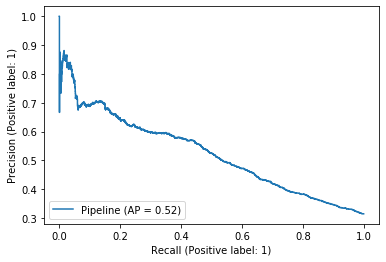

In [825]:
plot_precision_recall_curve(finalModel,X_test,y_test)

From the graph, we can see its not possible to find a balance between Recall and Precision, so we will try to get find thresholds that get both metric as high as possible

In [834]:
precision, recall, thresholds = precision_recall_curve(y_test,y_prob)

In [835]:
precisionRecall =pd.DataFrame({'Precision':precision[:-1],
             'Recall':recall[:-1],
             'Tresholds':thresholds}).sort_values(['Recall','Precision'])

We decided to set a certain amount into precision (minimum 0.4) and get the highest recall

In [837]:
precisionRecall[(precisionRecall['Precision']>0.40)].sort_values('Recall',ascending=False).head()

,Precision,Recall,Tresholds
1856,0.400140,0.741461,0.099691
1858,0.400374,0.741029,0.100624
1857,0.400093,0.741029,0.099918
1859,0.400140,0.739732,0.101861
1867,0.401408,0.739300,0.105916


We found that the best treshold would be 0.099691

In [838]:
y_prob=finalModel.predict_proba(X_test)[:,1]
y_pred=np.where(y_prob>0.099691,1,0)

In [839]:
confusion_matrix(y_test,y_pred)

array([[2466, 2570],
       [ 599, 1714]], dtype=int64)

In [840]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.49      0.61      5036
           1       0.40      0.74      0.52      2313

    accuracy                           0.57      7349
   macro avg       0.60      0.62      0.56      7349
weighted avg       0.68      0.57      0.58      7349



Here are the final result, although f1 score doesn't seem very good. But, we get what we expected

In [841]:
finalModel.fit(X,y) # FINAL MODEL, fit ke x dan y untuk memaksimalkan jumlah data yang dipelajari oleh model
file_name = 'ModelFinal.sav'
pickle.dump(finalModel, open(file_name,'wb'))

[00:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Summary

The result might not very good in overall report, but we achieved out target by getting recall in class 1 as high as possible. The imbalance data between class really affecting the model.<br><br>
The result could be improve in several factor on the next modeling:
    * More Data, especially in Bad Client
    * Try ensemble classification
    * More complex Hyperparameter Tuning